
[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


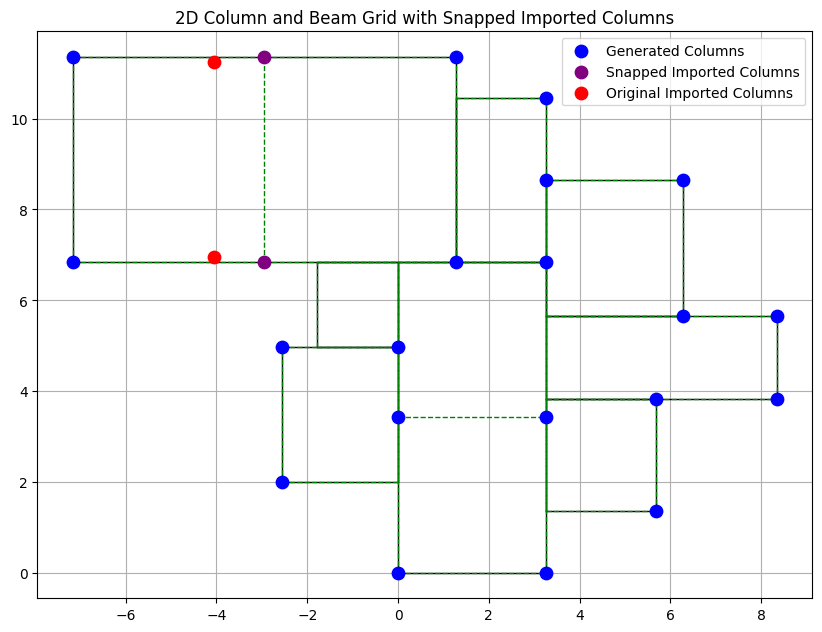

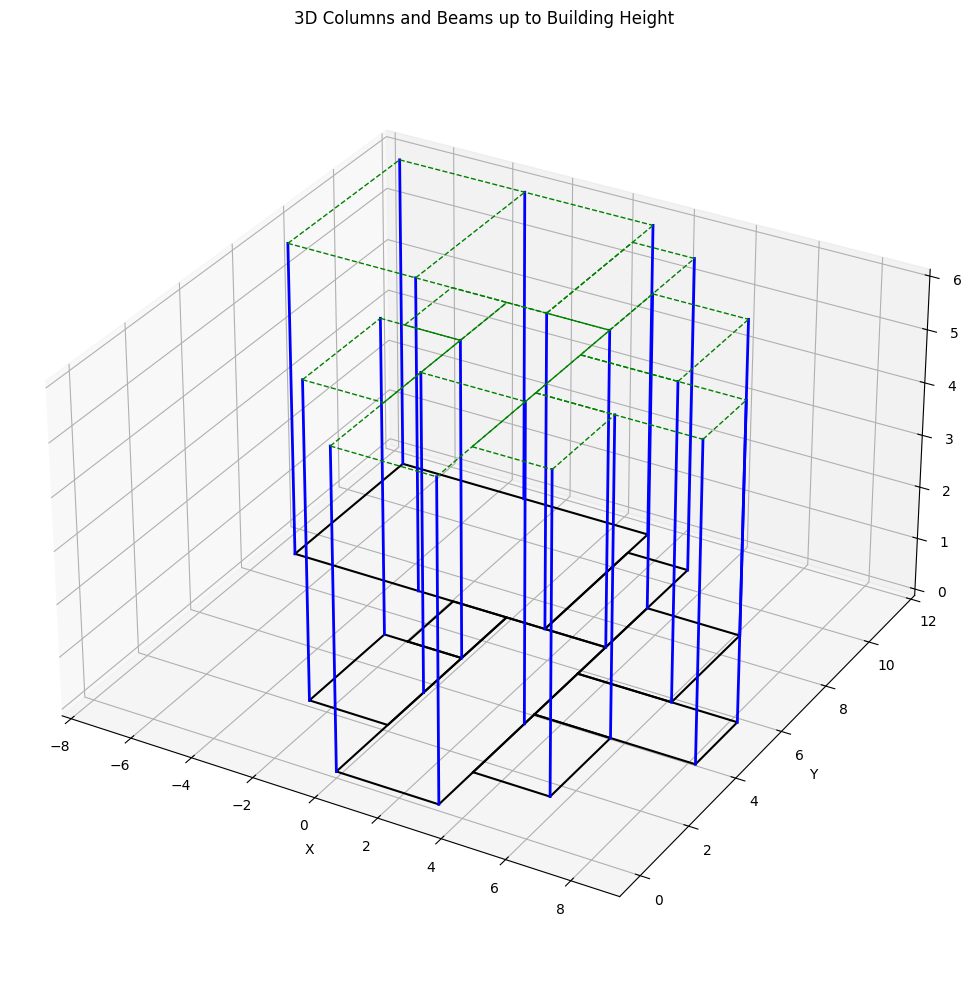

In [6]:
# 1. Install dependencies
!pip install -q rhino3dm shapely trimesh matplotlib

# 2. Imports
import rhino3dm
import numpy as np
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os

# 3. File path
rhino_path = r"C:\Users\papad\Documents\GitHub\Octopusie\Reference Files\rectangles3dcantilever.3dm"
if not os.path.exists(rhino_path):
    raise FileNotFoundError(f"File not found: {rhino_path}")

# 4. Load model
model = rhino3dm.File3dm.Read(rhino_path)
layers = {layer.Name.lower(): layer.Index for layer in model.Layers}
if 'building' not in layers or ('column' not in layers and 'columns' not in layers):
    raise RuntimeError("Missing required layers: 'building' and 'column' or 'columns'.")

column_layer = 'columns' if 'columns' in layers else 'column'

# 5. Extract building volume & get height
building_volumes = []
imported_columns = []
max_z = 0.0

for obj in model.Objects:
    layer_idx = obj.Attributes.LayerIndex
    geom = obj.Geometry

    if layer_idx == layers['building'] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        base_pts = [
            [bbox.Min.X, bbox.Min.Y],
            [bbox.Max.X, bbox.Min.Y],
            [bbox.Max.X, bbox.Max.Y],
            [bbox.Min.X, bbox.Max.Y]
        ]
        building_volumes.append(Polygon(base_pts))
        max_z = max(max_z, bbox.Max.Z)

    elif layer_idx == layers[column_layer] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        center_x = (bbox.Min.X + bbox.Max.X) / 2
        center_y = (bbox.Min.Y + bbox.Max.Y) / 2
        imported_columns.append((center_x, center_y))

if not building_volumes:
    raise RuntimeError("No valid building geometry found on the 'building' layer.")

# 6. Room sorting
detected_rooms = sorted([(poly, poly.area) for poly in building_volumes], key=lambda x: -x[1])

# 7. Structural logic
MaxS = 6.0
MinS = 3.0

columns = []
corrected_columns = []
available_imported = imported_columns.copy()
existing_columns = imported_columns.copy()
beams = []

for room_poly, _ in detected_rooms:
    minx, miny, maxx, maxy = room_poly.bounds
    width, height = maxx - minx, maxy - miny
    divisions_x = int(np.ceil(width / MaxS))
    divisions_y = int(np.ceil(height / MaxS))
    x_points = np.linspace(minx, maxx, divisions_x + 1)
    y_points = np.linspace(miny, maxy, divisions_y + 1)
    room_candidates = [(x, y) for x in x_points for y in y_points]

    for col in room_candidates:
        snap = False
        for imp_col in available_imported:
            if np.linalg.norm(np.array(col) - np.array(imp_col)) < MinS:
                corrected_columns.append(col)
                existing_columns.append(col)
                available_imported.remove(imp_col)
                snap = True
                break
        if not snap and all(np.linalg.norm(np.array(col) - np.array(exist_col)) >= MinS for exist_col in existing_columns):
            columns.append(col)
            existing_columns.append(col)

    for x in x_points:
        beams.append(((x, miny), (x, maxy)))
    for y in y_points:
        beams.append(((minx, y), (maxx, y)))

    for corner in list(room_poly.exterior.coords):
        if all(np.linalg.norm(np.array(corner) - np.array(exist_col)) >= MinS * 0.5 for exist_col in existing_columns):
            columns.append(corner)
            existing_columns.append(corner)

# 8. Combine all base columns
all_base_columns = columns + corrected_columns

# 8. 2D Visualization
fig, ax = plt.subplots(figsize=(10, 10))

# Room outlines
for poly, _ in detected_rooms:
    px, py = poly.exterior.xy
    ax.plot(px, py, 'k-', linewidth=1)

# Generated columns
if columns:
    gx, gy = zip(*columns)
    ax.scatter(gx, gy, c='blue', s=80, label='Generated Columns', zorder=5)

# Snapped imported columns
if corrected_columns:
    cx, cy = zip(*corrected_columns)
    ax.scatter(cx, cy, c='purple', s=80, label='Snapped Imported Columns', zorder=7)

# Original imported columns
if imported_columns:
    ix, iy = zip(*imported_columns)
    ax.scatter(ix, iy, c='red', s=80, label='Original Imported Columns', zorder=10)

# Beams
for (x1, y1), (x2, y2) in beams:
    ax.plot([x1, x2], [y1, y2], 'green', linestyle='--', linewidth=1)

ax.set_aspect('equal', 'box')
ax.legend()
plt.title("2D Column and Beam Grid with Snapped Imported Columns")
ax.grid(True)
plt.show()

# 9. 3D Visualization
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot base outlines
for poly, _ in detected_rooms:
    x, y = poly.exterior.xy
    ax.plot(x, y, zs=0, zdir='z', color='black')

# Plot columns (vertical lines)
for x, y in all_base_columns:
    ax.plot([x, x], [y, y], [0, max_z], color='blue', linewidth=2)

# Plot beams at top height
for (x1, y1), (x2, y2) in beams:
    ax.plot([x1, x2], [y1, y2], [max_z, max_z], color='green', linestyle='--', linewidth=1)

# Style
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Height')
ax.set_title("3D Columns and Beams up to Building Height")
ax.set_box_aspect([1,1,0.6])
plt.tight_layout()
plt.show()



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


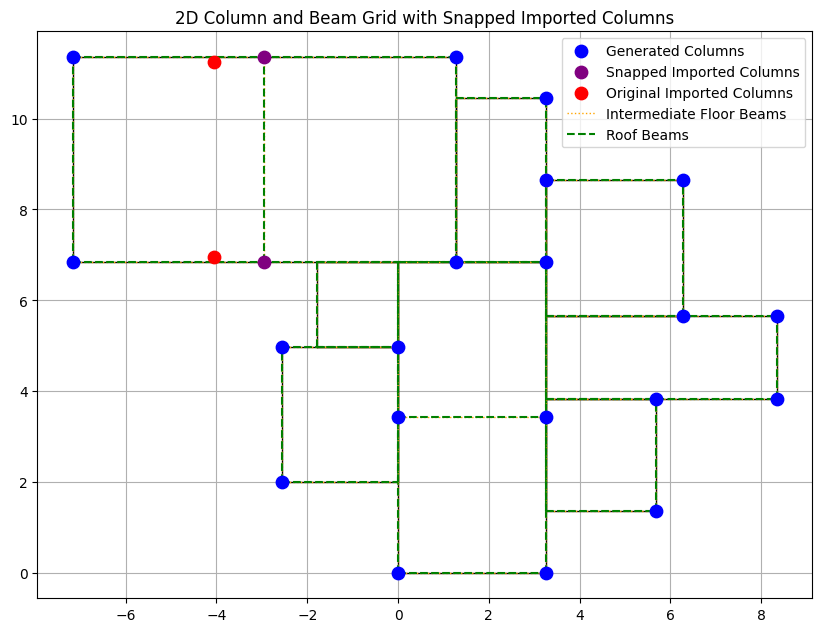

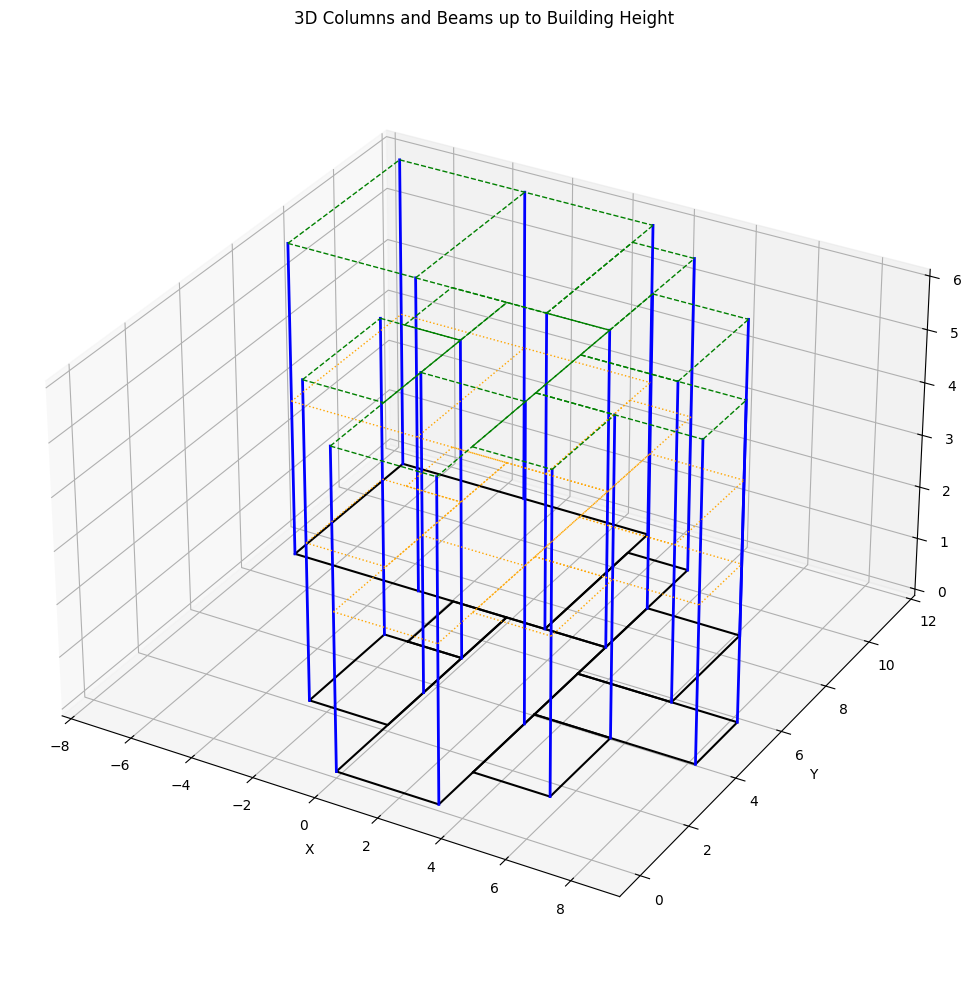

In [11]:
# 1. Install dependencies
!pip install -q rhino3dm shapely trimesh matplotlib

# 2. Imports
import rhino3dm
import numpy as np
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os

# 3. File path
rhino_path = r"C:\Users\papad\Documents\GitHub\Octopusie\Reference Files\rectangles3dcantilever.3dm"
if not os.path.exists(rhino_path):
    raise FileNotFoundError(f"File not found: {rhino_path}")

# 4. Load model
model = rhino3dm.File3dm.Read(rhino_path)
layers = {layer.Name.lower(): layer.Index for layer in model.Layers}
if 'building' not in layers or ('column' not in layers and 'columns' not in layers):
    raise RuntimeError("Missing required layers: 'building' and 'column' or 'columns'.")

column_layer = 'columns' if 'columns' in layers else 'column'

# 5. Extract building volume & get height
building_volumes = []
imported_columns = []
max_z = 0.0

for obj in model.Objects:
    layer_idx = obj.Attributes.LayerIndex
    geom = obj.Geometry

    if layer_idx == layers['building'] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        base_pts = [
            [bbox.Min.X, bbox.Min.Y],
            [bbox.Max.X, bbox.Min.Y],
            [bbox.Max.X, bbox.Max.Y],
            [bbox.Min.X, bbox.Max.Y]
        ]
        building_volumes.append(Polygon(base_pts))
        max_z = max(max_z, bbox.Max.Z)

    elif layer_idx == layers[column_layer] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        center_x = (bbox.Min.X + bbox.Max.X) / 2
        center_y = (bbox.Min.Y + bbox.Max.Y) / 2
        imported_columns.append((center_x, center_y))

if not building_volumes:
    raise RuntimeError("No valid building geometry found on the 'building' layer.")

# Ask the architect for number of floors
while True:
    try:
        num_floors = int(input("How many floors does the building have? (e.g., 2): "))
        if num_floors < 1:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive integer for the number of floors.")


# 6. Room sorting
detected_rooms = sorted([(poly, poly.area) for poly in building_volumes], key=lambda x: -x[1])

# 7. Structural logic
MaxS = 6.0
MinS = 3.0

columns = []
corrected_columns = []
available_imported = imported_columns.copy()
existing_columns = imported_columns.copy()
beams = []

for room_poly, _ in detected_rooms:
    minx, miny, maxx, maxy = room_poly.bounds
    width, height = maxx - minx, maxy - miny
    divisions_x = int(np.ceil(width / MaxS))
    divisions_y = int(np.ceil(height / MaxS))
    x_points = np.linspace(minx, maxx, divisions_x + 1)
    y_points = np.linspace(miny, maxy, divisions_y + 1)
    room_candidates = [(x, y) for x in x_points for y in y_points]

    for col in room_candidates:
        snap = False
        for imp_col in available_imported:
            if np.linalg.norm(np.array(col) - np.array(imp_col)) < MinS:
                corrected_columns.append(col)
                existing_columns.append(col)
                available_imported.remove(imp_col)
                snap = True
                break
        if not snap and all(np.linalg.norm(np.array(col) - np.array(exist_col)) >= MinS for exist_col in existing_columns):
            columns.append(col)
            existing_columns.append(col)

    for x in x_points:
        beams.append(((x, miny), (x, maxy)))
    for y in y_points:
        beams.append(((minx, y), (maxx, y)))

    for corner in list(room_poly.exterior.coords):
        if all(np.linalg.norm(np.array(corner) - np.array(exist_col)) >= MinS * 0.5 for exist_col in existing_columns):
            columns.append(corner)
            existing_columns.append(corner)

# 8. Combine all base columns
all_base_columns = columns + corrected_columns

# 8. 2D Visualization
fig, ax = plt.subplots(figsize=(10, 10))

# Room outlines
for poly, _ in detected_rooms:
    px, py = poly.exterior.xy
    ax.plot(px, py, 'k-', linewidth=1)

# Generated columns
if columns:
    gx, gy = zip(*columns)
    ax.scatter(gx, gy, c='blue', s=80, label='Generated Columns', zorder=5)

# Snapped imported columns
if corrected_columns:
    cx, cy = zip(*corrected_columns)
    ax.scatter(cx, cy, c='purple', s=80, label='Snapped Imported Columns', zorder=7)

# Original imported columns
if imported_columns:
    ix, iy = zip(*imported_columns)
    ax.scatter(ix, iy, c='red', s=80, label='Original Imported Columns', zorder=10)

intermediate_label_added = False
roof_label_added = False

for (x1, y1), (x2, y2) in beams:
    if num_floors > 1:
        for floor in range(1, num_floors):  # intermediate floors
            ax.plot([x1, x2], [y1, y2], color='orange', linestyle=':', linewidth=1,
                    label='Intermediate Floor Beams' if not intermediate_label_added else "")
            intermediate_label_added = True

    ax.plot([x1, x2], [y1, y2], color='green', linestyle='--', linewidth=1.5,
            label='Roof Beams' if not roof_label_added else "")
    roof_label_added = True



ax.set_aspect('equal', 'box')
ax.legend()
plt.title("2D Column and Beam Grid with Snapped Imported Columns")
ax.grid(True)
plt.show()

# 9. 3D Visualization
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot base outlines
for poly, _ in detected_rooms:
    x, y = poly.exterior.xy
    ax.plot(x, y, zs=0, zdir='z', color='black')

# Plot columns (vertical lines)
for x, y in all_base_columns:
    ax.plot([x, x], [y, y], [0, max_z], color='blue', linewidth=2)

# Plot beams at each floor level
for floor in range(1, num_floors + 1):
    z_level = (max_z / num_floors) * floor
    color = 'orange' if floor < num_floors else 'green'  # roof is green
    linestyle = ':' if floor < num_floors else '--'
    
    for (x1, y1), (x2, y2) in beams:
        ax.plot([x1, x2], [y1, y2], [z_level, z_level], color=color, linestyle=linestyle, linewidth=1)


# Style
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Height')
ax.set_title("3D Columns and Beams up to Building Height")
ax.set_box_aspect([1,1,0.6])
plt.tight_layout()
plt.show()



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


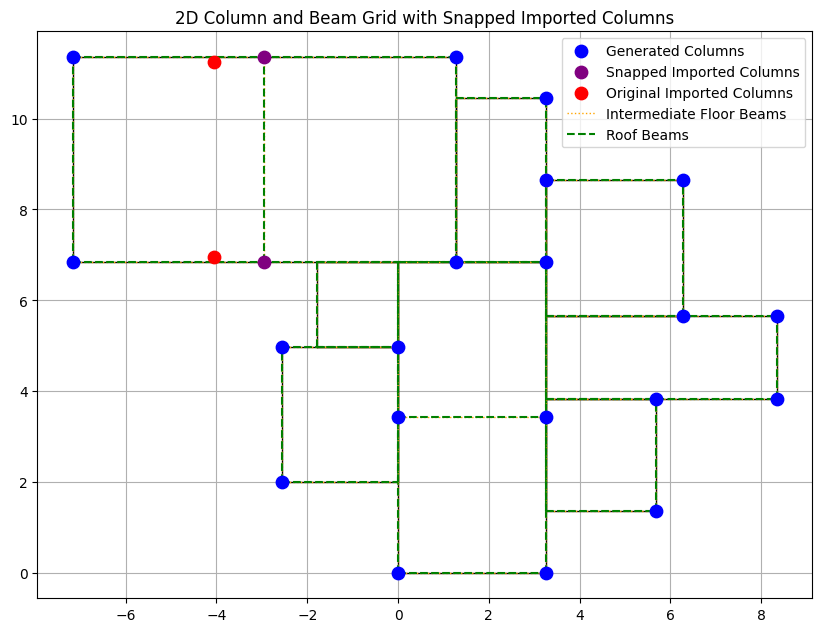

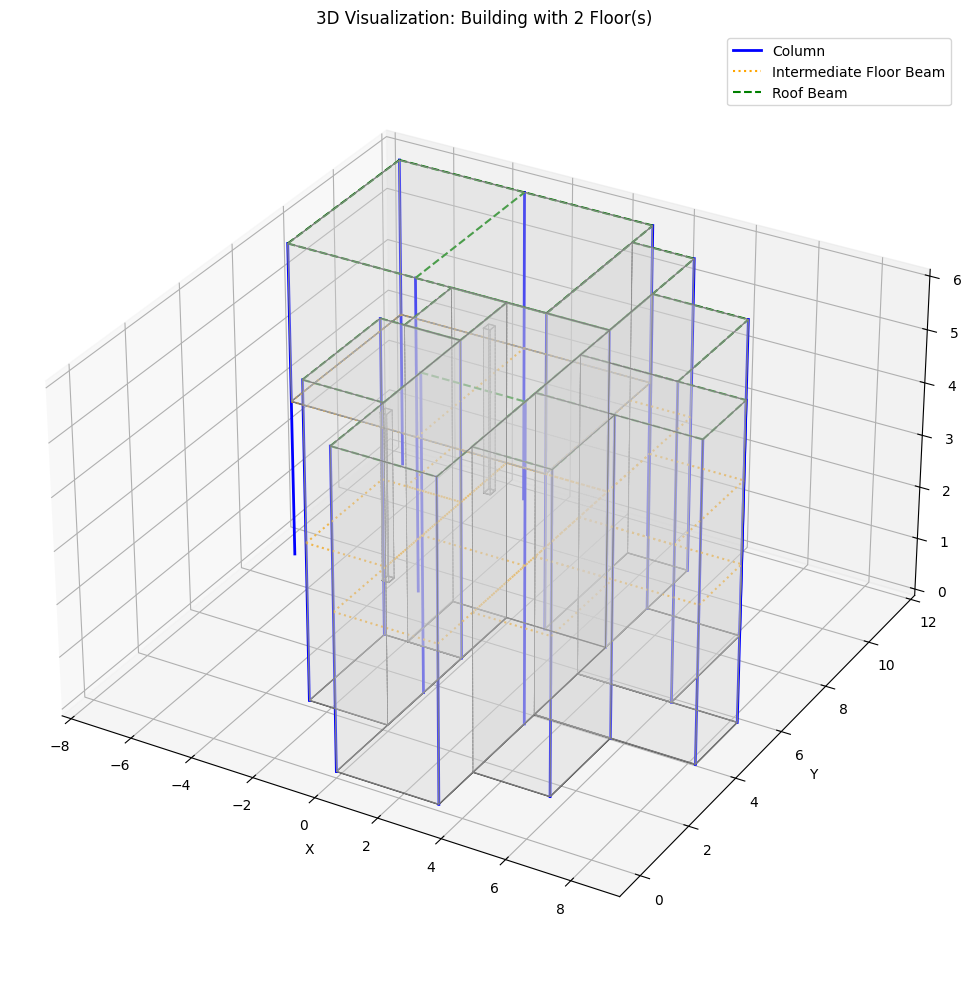

<Figure size 640x480 with 0 Axes>

In [13]:
# 1. Install dependencies
!pip install -q rhino3dm shapely trimesh matplotlib

# 2. Imports
import rhino3dm
import numpy as np
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os

# 3. File path
rhino_path = r"C:\Users\papad\Documents\GitHub\Octopusie\Reference Files\rectangles3dcantilever.3dm"
if not os.path.exists(rhino_path):
    raise FileNotFoundError(f"File not found: {rhino_path}")

# 4. Load model
model = rhino3dm.File3dm.Read(rhino_path)
layers = {layer.Name.lower(): layer.Index for layer in model.Layers}
if 'building' not in layers or ('column' not in layers and 'columns' not in layers):
    raise RuntimeError("Missing required layers: 'building' and 'column' or 'columns'.")

column_layer = 'columns' if 'columns' in layers else 'column'

# 5. Extract building volume & get height
building_volumes = []
imported_columns = []
max_z = 0.0

for obj in model.Objects:
    layer_idx = obj.Attributes.LayerIndex
    geom = obj.Geometry

    if layer_idx == layers['building'] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        base_pts = [
            [bbox.Min.X, bbox.Min.Y],
            [bbox.Max.X, bbox.Min.Y],
            [bbox.Max.X, bbox.Max.Y],
            [bbox.Min.X, bbox.Max.Y]
        ]
        building_volumes.append(Polygon(base_pts))
        max_z = max(max_z, bbox.Max.Z)

    elif layer_idx == layers[column_layer] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        center_x = (bbox.Min.X + bbox.Max.X) / 2
        center_y = (bbox.Min.Y + bbox.Max.Y) / 2
        imported_columns.append((center_x, center_y))

if not building_volumes:
    raise RuntimeError("No valid building geometry found on the 'building' layer.")

# Ask the architect for number of floors
while True:
    try:
        num_floors = int(input("How many floors does the building have? (e.g., 2): "))
        if num_floors < 1:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive integer for the number of floors.")


# 6. Room sorting
detected_rooms = sorted([(poly, poly.area) for poly in building_volumes], key=lambda x: -x[1])

# 7. Structural logic
MaxS = 6.0
MinS = 3.0

columns = []
corrected_columns = []
available_imported = imported_columns.copy()
existing_columns = imported_columns.copy()
beams = []

for room_poly, _ in detected_rooms:
    minx, miny, maxx, maxy = room_poly.bounds
    width, height = maxx - minx, maxy - miny
    divisions_x = int(np.ceil(width / MaxS))
    divisions_y = int(np.ceil(height / MaxS))
    x_points = np.linspace(minx, maxx, divisions_x + 1)
    y_points = np.linspace(miny, maxy, divisions_y + 1)
    room_candidates = [(x, y) for x in x_points for y in y_points]

    for col in room_candidates:
        snap = False
        for imp_col in available_imported:
            if np.linalg.norm(np.array(col) - np.array(imp_col)) < MinS:
                corrected_columns.append(col)
                existing_columns.append(col)
                available_imported.remove(imp_col)
                snap = True
                break
        if not snap and all(np.linalg.norm(np.array(col) - np.array(exist_col)) >= MinS for exist_col in existing_columns):
            columns.append(col)
            existing_columns.append(col)

    for x in x_points:
        beams.append(((x, miny), (x, maxy)))
    for y in y_points:
        beams.append(((minx, y), (maxx, y)))

    for corner in list(room_poly.exterior.coords):
        if all(np.linalg.norm(np.array(corner) - np.array(exist_col)) >= MinS * 0.5 for exist_col in existing_columns):
            columns.append(corner)
            existing_columns.append(corner)

# 8. Combine all base columns
all_base_columns = columns + corrected_columns

# 8. 2D Visualization
fig, ax = plt.subplots(figsize=(10, 10))

# Room outlines
for poly, _ in detected_rooms:
    px, py = poly.exterior.xy
    ax.plot(px, py, 'k-', linewidth=1)

# Generated columns
if columns:
    gx, gy = zip(*columns)
    ax.scatter(gx, gy, c='blue', s=80, label='Generated Columns', zorder=5)

# Snapped imported columns
if corrected_columns:
    cx, cy = zip(*corrected_columns)
    ax.scatter(cx, cy, c='purple', s=80, label='Snapped Imported Columns', zorder=7)

# Original imported columns
if imported_columns:
    ix, iy = zip(*imported_columns)
    ax.scatter(ix, iy, c='red', s=80, label='Original Imported Columns', zorder=10)

intermediate_label_added = False
roof_label_added = False

for (x1, y1), (x2, y2) in beams:
    if num_floors > 1:
        for floor in range(1, num_floors):  # intermediate floors
            ax.plot([x1, x2], [y1, y2], color='orange', linestyle=':', linewidth=1,
                    label='Intermediate Floor Beams' if not intermediate_label_added else "")
            intermediate_label_added = True

    ax.plot([x1, x2], [y1, y2], color='green', linestyle='--', linewidth=1.5,
            label='Roof Beams' if not roof_label_added else "")
    roof_label_added = True



ax.set_aspect('equal', 'box')
ax.legend()
plt.title("2D Column and Beam Grid with Snapped Imported Columns")
ax.grid(True)
plt.show()

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Plot building walls as translucent volumes
for obj in model.Objects:
    geom = obj.Geometry
    if geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        # Create 8 corners of the box
        x0, x1 = bbox.Min.X, bbox.Max.X
        y0, y1 = bbox.Min.Y, bbox.Max.Y
        z0, z1 = bbox.Min.Z, bbox.Max.Z
        verts = [
            [[x0, y0, z0], [x1, y0, z0], [x1, y1, z0], [x0, y1, z0]],  # bottom
            [[x0, y0, z1], [x1, y0, z1], [x1, y1, z1], [x0, y1, z1]],  # top
            [[x0, y0, z0], [x1, y0, z0], [x1, y0, z1], [x0, y0, z1]],  # front
            [[x1, y0, z0], [x1, y1, z0], [x1, y1, z1], [x1, y0, z1]],  # right
            [[x0, y1, z0], [x1, y1, z0], [x1, y1, z1], [x0, y1, z1]],  # back
            [[x0, y0, z0], [x0, y1, z0], [x0, y1, z1], [x0, y0, z1]],  # left
        ]
        ax.add_collection3d(Poly3DCollection(verts, facecolors='lightgray', linewidths=0.5, edgecolors='gray', alpha=0.2))

# 1. Visualize geometry from 3DM model
for obj in model.Objects:
    geom = obj.Geometry
    if geom.ObjectType == rhino3dm.ObjectType.Brep:
        # Visualize Brep bounding boxes as wireframes (simplified)
        bbox = geom.GetBoundingBox()
        x = [bbox.Min.X, bbox.Max.X, bbox.Max.X, bbox.Min.X, bbox.Min.X]
        y = [bbox.Min.Y, bbox.Min.Y, bbox.Max.Y, bbox.Max.Y, bbox.Min.Y]
        z_bottom = [bbox.Min.Z] * 5
        z_top = [bbox.Max.Z] * 5

        # Base
        ax.plot(x, y, z_bottom, color='black', linestyle='-', linewidth=1)
        # Top
        ax.plot(x, y, z_top, color='gray', linestyle='-', linewidth=1)
        # Vertical edges
        for i in range(4):
            ax.plot([x[i], x[i]], [y[i], y[i]], [bbox.Min.Z, bbox.Max.Z], color='black', linestyle='--', linewidth=0.5)

# 2. Plot columns (as vertical lines)
for x, y in all_base_columns:
    ax.plot([x, x], [y, y], [0, max_z], color='blue', linewidth=2, label='Column' if 'Column' not in ax.get_legend_handles_labels()[1] else "")

# 3. Plot beams at each floor level
intermediate_label_added = False
roof_label_added = False

for (x1, y1), (x2, y2) in beams:
    for floor in range(1, num_floors + 1):
        z_level = (max_z / num_floors) * floor
        color = 'orange' if floor < num_floors else 'green'
        linestyle = ':' if floor < num_floors else '--'
        label = 'Intermediate Floor Beam' if floor < num_floors and not intermediate_label_added else \
                'Roof Beam' if floor == num_floors and not roof_label_added else ""
        
        ax.plot([x1, x2], [y1, y2], [z_level, z_level], color=color, linestyle=linestyle, linewidth=1.5, label=label)
        
        if floor < num_floors:
            intermediate_label_added = True
        else:
            roof_label_added = True

# Style
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f"3D Visualization: Building with {num_floors} Floor(s)")
ax.set_box_aspect([1,1,0.6])
ax.legend()
plt.tight_layout()
plt.show()


# Plot base outlines
for poly, _ in detected_rooms:
    x, y = poly.exterior.xy
    ax.plot(x, y, zs=0, zdir='z', color='black')

# Plot columns (vertical lines)
for x, y in all_base_columns:
    ax.plot([x, x], [y, y], [0, max_z], color='blue', linewidth=2)

# Plot beams at each floor level
for floor in range(1, num_floors + 1):
    z_level = (max_z / num_floors) * floor
    color = 'orange' if floor < num_floors else 'green'  # roof is green
    linestyle = ':' if floor < num_floors else '--'
    
    for (x1, y1), (x2, y2) in beams:
        ax.plot([x1, x2], [y1, y2], [z_level, z_level], color=color, linestyle=linestyle, linewidth=1)


# Style
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Height')
ax.set_title("3D Columns and Beams up to Building Height")
ax.set_box_aspect([1,1,0.6])
plt.tight_layout()
plt.show()


In [2]:
pip install vedo

   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   --- ------------------------------------ 0.3/2.8 MB ? eta -:--:--
   --- ------------------------------------ 0.3/2.8 MB ? eta -:--:--
   --- ------------------------------------ 0.3/2.8 MB ? eta -:--:--
   --- ---------------------------


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


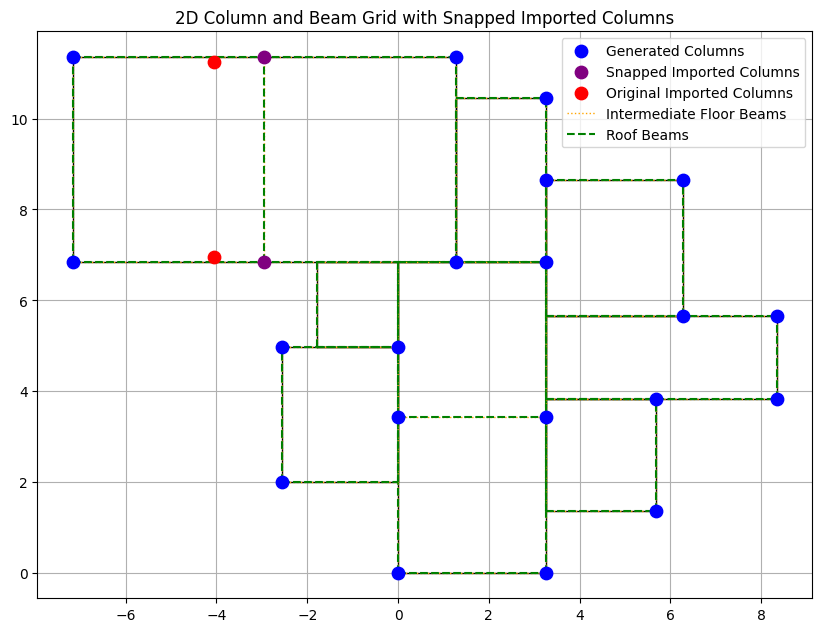

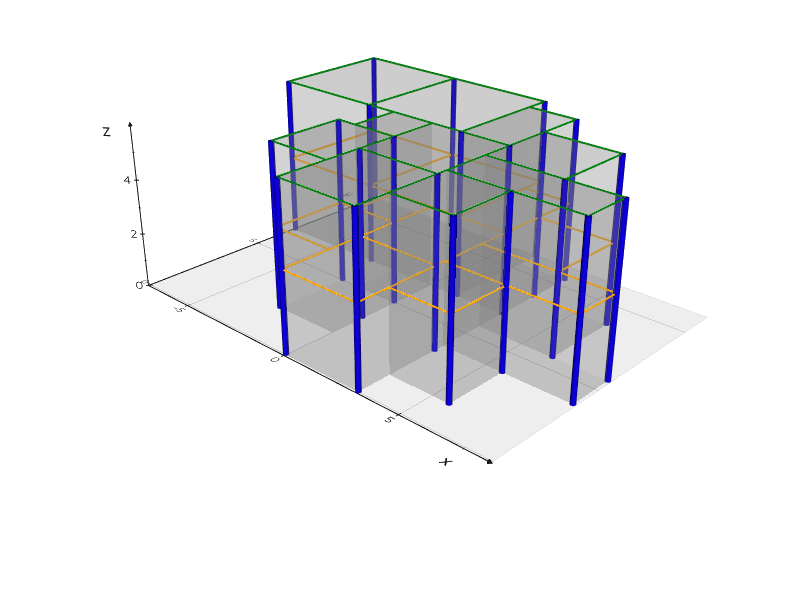

In [5]:
# 1. Install dependencies
!pip install -q rhino3dm shapely trimesh matplotlib

# 2. Imports
import rhino3dm
import numpy as np
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os

import os
import numpy as np
import rhino3dm
from shapely.geometry import Polygon
from vedo import Plotter, Lines, Cylinder, Box


# File path
rhino_path = r"C:\Users\papad\Documents\GitHub\Octopusie\Reference Files\rectangles3dcantilever.3dm"
if not os.path.exists(rhino_path):
    raise FileNotFoundError(f"File not found: {rhino_path}")

# Load model
model = rhino3dm.File3dm.Read(rhino_path)
layers = {layer.Name.lower(): layer.Index for layer in model.Layers}
if 'building' not in layers or ('column' not in layers and 'columns' not in layers):
    raise RuntimeError("Missing required layers: 'building' and 'column' or 'columns'.")

column_layer = 'columns' if 'columns' in layers else 'column'

# Extract building volume & height
building_volumes = []
imported_columns = []
max_z = 0.0

for obj in model.Objects:
    layer_idx = obj.Attributes.LayerIndex
    geom = obj.Geometry

    if layer_idx == layers['building'] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        base_pts = [
            [bbox.Min.X, bbox.Min.Y],
            [bbox.Max.X, bbox.Min.Y],
            [bbox.Max.X, bbox.Max.Y],
            [bbox.Min.X, bbox.Max.Y]
        ]
        building_volumes.append(Polygon(base_pts))
        max_z = max(max_z, bbox.Max.Z)

    elif layer_idx == layers[column_layer] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        center_x = (bbox.Min.X + bbox.Max.X) / 2
        center_y = (bbox.Min.Y + bbox.Max.Y) / 2
        imported_columns.append((center_x, center_y))

if not building_volumes:
    raise RuntimeError("No valid building geometry found on the 'building' layer.")

# Ask for number of floors
while True:
    try:
        num_floors = int(input("How many floors does the building have? (e.g., 2): "))
        if num_floors < 1:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive integer for the number of floors.")

# Room sorting
detected_rooms = sorted([(poly, poly.area) for poly in building_volumes], key=lambda x: -x[1])

# Structural logic
MaxS = 6.0
MinS = 3.0

columns = []
corrected_columns = []
available_imported = imported_columns.copy()
existing_columns = imported_columns.copy()
beams = []

for room_poly, _ in detected_rooms:
    minx, miny, maxx, maxy = room_poly.bounds
    width, height = maxx - minx, maxy - miny
    divisions_x = int(np.ceil(width / MaxS))
    divisions_y = int(np.ceil(height / MaxS))
    x_points = np.linspace(minx, maxx, divisions_x + 1)
    y_points = np.linspace(miny, maxy, divisions_y + 1)
    room_candidates = [(x, y) for x in x_points for y in y_points]

    for col in room_candidates:
        snap = False
        for imp_col in available_imported:
            if np.linalg.norm(np.array(col) - np.array(imp_col)) < MinS:
                corrected_columns.append(col)
                existing_columns.append(col)
                available_imported.remove(imp_col)
                snap = True
                break
        if not snap and all(np.linalg.norm(np.array(col) - np.array(exist_col)) >= MinS for exist_col in existing_columns):
            columns.append(col)
            existing_columns.append(col)

    for x in x_points:
        beams.append(((x, miny), (x, maxy)))
    for y in y_points:
        beams.append(((minx, y), (maxx, y)))

    for corner in list(room_poly.exterior.coords):
        if all(np.linalg.norm(np.array(corner) - np.array(exist_col)) >= MinS * 0.5 for exist_col in existing_columns):
            columns.append(corner)
            existing_columns.append(corner)

# Combine all base columns
all_base_columns = columns + corrected_columns


# 8. 2D Visualization
fig, ax = plt.subplots(figsize=(10, 10))

# Room outlines
for poly, _ in detected_rooms:
    px, py = poly.exterior.xy
    ax.plot(px, py, 'k-', linewidth=1)

# Generated columns
if columns:
    gx, gy = zip(*columns)
    ax.scatter(gx, gy, c='blue', s=80, label='Generated Columns', zorder=5)

# Snapped imported columns
if corrected_columns:
    cx, cy = zip(*corrected_columns)
    ax.scatter(cx, cy, c='purple', s=80, label='Snapped Imported Columns', zorder=7)

# Original imported columns
if imported_columns:
    ix, iy = zip(*imported_columns)
    ax.scatter(ix, iy, c='red', s=80, label='Original Imported Columns', zorder=10)

intermediate_label_added = False
roof_label_added = False

for (x1, y1), (x2, y2) in beams:
    if num_floors > 1:
        for floor in range(1, num_floors):  # intermediate floors
            ax.plot([x1, x2], [y1, y2], color='orange', linestyle=':', linewidth=1,
                    label='Intermediate Floor Beams' if not intermediate_label_added else "")
            intermediate_label_added = True

    ax.plot([x1, x2], [y1, y2], color='green', linestyle='--', linewidth=1.5,
            label='Roof Beams' if not roof_label_added else "")
    roof_label_added = True



ax.set_aspect('equal', 'box')
ax.legend()
plt.title("2D Column and Beam Grid with Snapped Imported Columns")
ax.grid(True)
plt.show()


# vedo 3D interactive viewer
vp = Plotter(title="3D Structural System", axes=1, bg="white")

# Columns as vertical cylinders
for x, y in all_base_columns:
    c = Cylinder(pos=(x, y, max_z / 2), r=0.1, height=max_z, axis=(0, 0, 1), c='blue')
    vp += c

# Beams at each floor level
for (x1, y1), (x2, y2) in beams:
    for floor in range(1, num_floors + 1):
        z = (max_z / num_floors) * floor
        line = Lines([(x1, y1, z)], [(x2, y2, z)], c='green' if floor == num_floors else 'orange', lw=2)
        vp += line

# Translucent building box
for poly, _ in detected_rooms:
    minx, miny, maxx, maxy = poly.bounds
    box = Box(pos=((minx + maxx) / 2, (miny + maxy) / 2, max_z / 2),
              length=maxx - minx, width=maxy - miny, height=max_z,
              c='lightgray', alpha=0.2)
    vp += box

# Show interactive 3D viewer
vp.show(viewup='z', interactive=True)



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


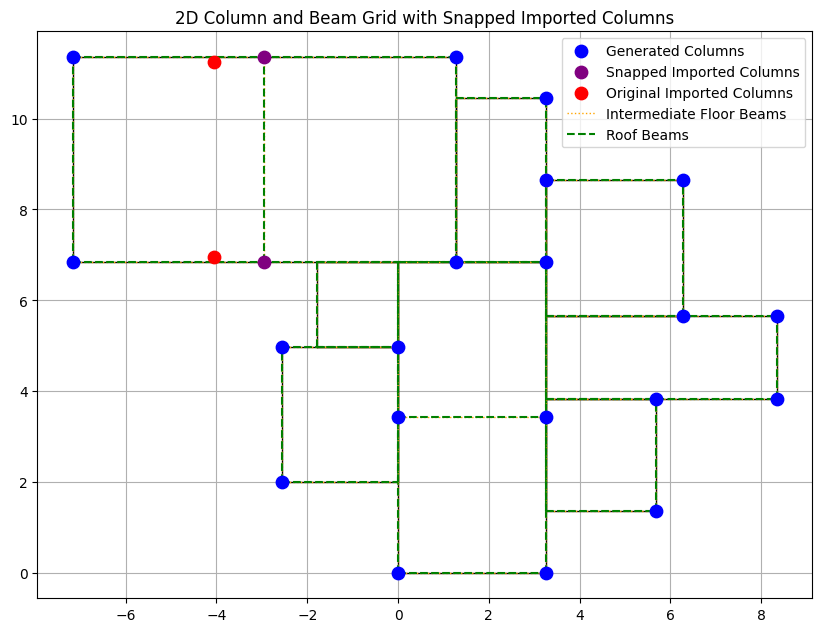

Widget(value='<iframe src="http://localhost:64461/index.html?ui=P_0x1e323f79160_0&reconnect=auto" class="pyvis…

c:\Users\papad\Desktop\IAAC\2ndTerm\Studio2\structuralstuff\studio2\Lib\site-packages\pyvista\core\utilities\misc.py:221: UserWarning: Encountered issue in callback (most recent call last):
  File "c:\Users\papad\Desktop\IAAC\2ndTerm\Studio2\structuralstuff\studio2\Lib\site-packages\pyvista\plotting\picking.py", line 1036, in end_pick_call_back
    warnings.warn('Unable to show mesh when picking:\n\n%s', str(e))  # type: ignore[call-overload]
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: category must be a Warning subclass, not 'str'
  warnings.warn(formatted_exception)


Column selected → 1 total.


c:\Users\papad\Desktop\IAAC\2ndTerm\Studio2\structuralstuff\studio2\Lib\site-packages\pyvista\core\utilities\misc.py:221: UserWarning: Encountered issue in callback (most recent call last):
  File "c:\Users\papad\Desktop\IAAC\2ndTerm\Studio2\structuralstuff\studio2\Lib\site-packages\pyvista\plotting\picking.py", line 1036, in end_pick_call_back
    warnings.warn('Unable to show mesh when picking:\n\n%s', str(e))  # type: ignore[call-overload]
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: category must be a Warning subclass, not 'str'
  warnings.warn(formatted_exception)


Wall selected   → 1 total.
Column selected → 2 total.
Wall selected   → 2 total.
Wall selected   → 3 total.
Wall selected   → 4 total.
Wall selected   → 5 total.
Column selected → 3 total.
Column selected → 4 total.
Column selected → 5 total.


In [12]:
# 1. Install dependencies
!pip install -q rhino3dm shapely trimesh matplotlib pyvista

# 2. Imports
import rhino3dm
import numpy as np
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import pyvista as pv

# File path
rhino_path = r"C:\Users\papad\Documents\GitHub\Octopusie\Reference Files\rectangles3dcantilever.3dm"
if not os.path.exists(rhino_path):
    raise FileNotFoundError(f"File not found: {rhino_path}")

# Load model
model = rhino3dm.File3dm.Read(rhino_path)
layers = {layer.Name.lower(): layer.Index for layer in model.Layers}
if 'building' not in layers or ('column' not in layers and 'columns' not in layers):
    raise RuntimeError("Missing required layers: 'building' and 'column' or 'columns'.")

column_layer = 'columns' if 'columns' in layers else 'column'

# Extract building volume & height
building_volumes = []
imported_columns = []
max_z = 0.0

for obj in model.Objects:
    layer_idx = obj.Attributes.LayerIndex
    geom = obj.Geometry

    if layer_idx == layers['building'] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        base_pts = [
            [bbox.Min.X, bbox.Min.Y],
            [bbox.Max.X, bbox.Min.Y],
            [bbox.Max.X, bbox.Max.Y],
            [bbox.Min.X, bbox.Max.Y]
        ]
        building_volumes.append(Polygon(base_pts))
        max_z = max(max_z, bbox.Max.Z)

    elif layer_idx == layers[column_layer] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        center_x = (bbox.Min.X + bbox.Max.X) / 2
        center_y = (bbox.Min.Y + bbox.Max.Y) / 2
        imported_columns.append((center_x, center_y))

if not building_volumes:
    raise RuntimeError("No valid building geometry found on the 'building' layer.")

# Ask for number of floors
while True:
    try:
        num_floors = int(input("How many floors does the building have? (e.g., 2): "))
        if num_floors < 1:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive integer for the number of floors.")

# Room sorting
detected_rooms = sorted([(poly, poly.area) for poly in building_volumes], key=lambda x: -x[1])

# Structural logic
MaxS = 6.0
MinS = 3.0

columns = []
corrected_columns = []
available_imported = imported_columns.copy()
existing_columns = imported_columns.copy()
beams = []

for room_poly, _ in detected_rooms:
    minx, miny, maxx, maxy = room_poly.bounds
    width, height = maxx - minx, maxy - miny
    divisions_x = int(np.ceil(width / MaxS))
    divisions_y = int(np.ceil(height / MaxS))
    x_points = np.linspace(minx, maxx, divisions_x + 1)
    y_points = np.linspace(miny, maxy, divisions_y + 1)
    room_candidates = [(x, y) for x in x_points for y in y_points]

    for col in room_candidates:
        snap = False
        for imp_col in available_imported:
            if np.linalg.norm(np.array(col) - np.array(imp_col)) < MinS:
                corrected_columns.append(col)
                existing_columns.append(col)
                available_imported.remove(imp_col)
                snap = True
                break
        if not snap and all(np.linalg.norm(np.array(col) - np.array(exist_col)) >= MinS for exist_col in existing_columns):
            columns.append(col)
            existing_columns.append(col)

    for x in x_points:
        beams.append(((x, miny), (x, maxy)))
    for y in y_points:
        beams.append(((minx, y), (maxx, y)))

    for corner in list(room_poly.exterior.coords):
        if all(np.linalg.norm(np.array(corner) - np.array(exist_col)) >= MinS * 0.5 for exist_col in existing_columns):
            columns.append(corner)
            existing_columns.append(corner)

# Combine all base columns
all_base_columns = columns + corrected_columns

# 8. 2D Visualization (same as before)
fig, ax = plt.subplots(figsize=(10, 10))

# Room outlines
for poly, _ in detected_rooms:
    px, py = poly.exterior.xy
    ax.plot(px, py, 'k-', linewidth=1)

# Generated columns
if columns:
    gx, gy = zip(*columns)
    ax.scatter(gx, gy, c='blue', s=80, label='Generated Columns', zorder=5)

# Snapped imported columns
if corrected_columns:
    cx, cy = zip(*corrected_columns)
    ax.scatter(cx, cy, c='purple', s=80, label='Snapped Imported Columns', zorder=7)

# Original imported columns
if imported_columns:
    ix, iy = zip(*imported_columns)
    ax.scatter(ix, iy, c='red', s=80, label='Original Imported Columns', zorder=10)

intermediate_label_added = False
roof_label_added = False

for (x1, y1), (x2, y2) in beams:
    if num_floors > 1:
        for floor in range(1, num_floors):  # intermediate floors
            ax.plot([x1, x2], [y1, y2], color='orange', linestyle=':', linewidth=1,
                    label='Intermediate Floor Beams' if not intermediate_label_added else "")
            intermediate_label_added = True

    ax.plot([x1, x2], [y1, y2], color='green', linestyle='--', linewidth=1.5,
            label='Roof Beams' if not roof_label_added else "")
    roof_label_added = True

ax.set_aspect('equal', 'box')
ax.legend()
plt.title("2D Column and Beam Grid with Snapped Imported Columns")
ax.grid(True)
plt.show()

# PyVista 3D visualization
plotter = pv.Plotter(title="3D Structural System")

# Columns as vertical cylinders
for x, y in all_base_columns:
    cylinder = pv.Cylinder(center=(x, y, max_z/2), direction=(0, 0, 1), 
                          radius=0.1, height=max_z)
    plotter.add_mesh(cylinder, color='blue')

# Beams at each floor level
for (x1, y1), (x2, y2) in beams:
    for floor in range(1, num_floors + 1):
        z = (max_z / num_floors) * floor
        line = pv.Line((x1, y1, z), (x2, y2, z))
        plotter.add_mesh(line, color='green' if floor == num_floors else 'orange', line_width=2)

# Translucent building box
for poly, _ in detected_rooms:
    minx, miny, maxx, maxy = poly.bounds
    box = pv.Box(bounds=(minx, maxx, miny, maxy, 0, max_z))
    plotter.add_mesh(box, color='lightgray', opacity=0.2)

# Set up the camera and show
plotter.show_grid()
plotter.show()


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


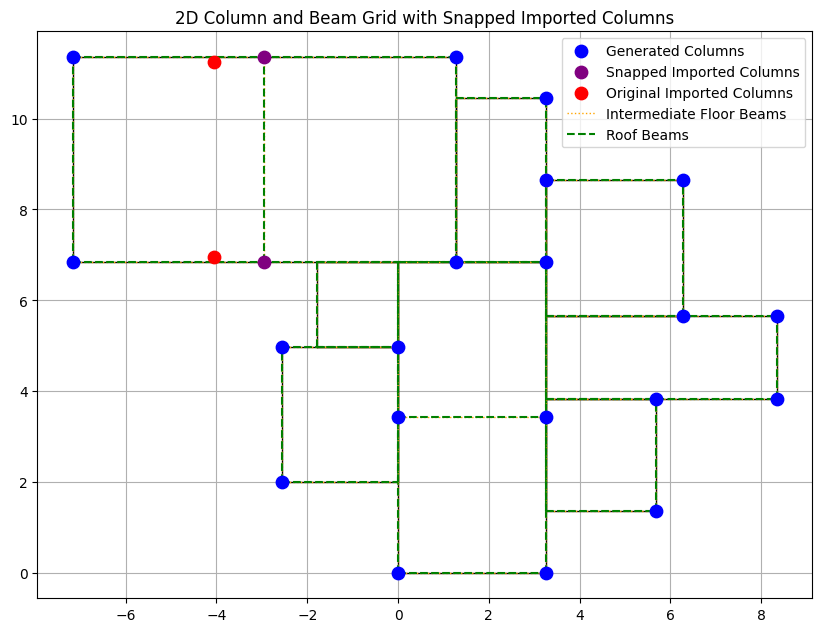

AttributeError: 'tuple' object has no attribute 'IsTriangle'

In [1]:
# 1. Install dependencies
!pip install -q rhino3dm shapely trimesh matplotlib pyvista

# 2. Imports
import rhino3dm
import numpy as np
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import pyvista as pv

# File path
rhino_path = r"C:\Users\papad\Documents\GitHub\Octopusie\Reference Files\rectangles3dcantilever.3dm"
if not os.path.exists(rhino_path):
    raise FileNotFoundError(f"File not found: {rhino_path}")

# Load model
model = rhino3dm.File3dm.Read(rhino_path)
layers = {layer.Name.lower(): layer.Index for layer in model.Layers}
if 'building' not in layers or ('column' not in layers and 'columns' not in layers):
    raise RuntimeError("Missing required layers: 'building' and 'column' or 'columns'.")

column_layer = 'columns' if 'columns' in layers else 'column'

# Extract building volume & height
building_volumes = []
imported_columns = []
max_z = 0.0

for obj in model.Objects:
    layer_idx = obj.Attributes.LayerIndex
    geom = obj.Geometry

    if layer_idx == layers['building'] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        base_pts = [
            [bbox.Min.X, bbox.Min.Y],
            [bbox.Max.X, bbox.Min.Y],
            [bbox.Max.X, bbox.Max.Y],
            [bbox.Min.X, bbox.Max.Y]
        ]
        building_volumes.append(Polygon(base_pts))
        max_z = max(max_z, bbox.Max.Z)

    elif layer_idx == layers[column_layer] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        center_x = (bbox.Min.X + bbox.Max.X) / 2
        center_y = (bbox.Min.Y + bbox.Max.Y) / 2
        imported_columns.append((center_x, center_y))

if not building_volumes:
    raise RuntimeError("No valid building geometry found on the 'building' layer.")

# Ask for number of floors
while True:
    try:
        num_floors = int(input("How many floors does the building have? (e.g., 2): "))
        if num_floors < 1:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive integer for the number of floors.")

# Room sorting
detected_rooms = sorted([(poly, poly.area) for poly in building_volumes], key=lambda x: -x[1])

# Structural logic
MaxS = 6.0
MinS = 3.0

columns = []
corrected_columns = []
available_imported = imported_columns.copy()
existing_columns = imported_columns.copy()
beams = []

for room_poly, _ in detected_rooms:
    minx, miny, maxx, maxy = room_poly.bounds
    width, height = maxx - minx, maxy - miny
    divisions_x = int(np.ceil(width / MaxS))
    divisions_y = int(np.ceil(height / MaxS))
    x_points = np.linspace(minx, maxx, divisions_x + 1)
    y_points = np.linspace(miny, maxy, divisions_y + 1)
    room_candidates = [(x, y) for x in x_points for y in y_points]

    for col in room_candidates:
        snap = False
        for imp_col in available_imported:
            if np.linalg.norm(np.array(col) - np.array(imp_col)) < MinS:
                corrected_columns.append(col)
                existing_columns.append(col)
                available_imported.remove(imp_col)
                snap = True
                break
        if not snap and all(np.linalg.norm(np.array(col) - np.array(exist_col)) >= MinS for exist_col in existing_columns):
            columns.append(col)
            existing_columns.append(col)

    for x in x_points:
        beams.append(((x, miny), (x, maxy)))
    for y in y_points:
        beams.append(((minx, y), (maxx, y)))

    for corner in list(room_poly.exterior.coords):
        if all(np.linalg.norm(np.array(corner) - np.array(exist_col)) >= MinS * 0.5 for exist_col in existing_columns):
            columns.append(corner)
            existing_columns.append(corner)

# Combine all base columns
all_base_columns = columns + corrected_columns

# 8. 2D Visualization (same as before)
fig, ax = plt.subplots(figsize=(10, 10))

# Room outlines
for poly, _ in detected_rooms:
    px, py = poly.exterior.xy
    ax.plot(px, py, 'k-', linewidth=1)

# Generated columns
if columns:
    gx, gy = zip(*columns)
    ax.scatter(gx, gy, c='blue', s=80, label='Generated Columns', zorder=5)

# Snapped imported columns
if corrected_columns:
    cx, cy = zip(*corrected_columns)
    ax.scatter(cx, cy, c='purple', s=80, label='Snapped Imported Columns', zorder=7)

# Original imported columns
if imported_columns:
    ix, iy = zip(*imported_columns)
    ax.scatter(ix, iy, c='red', s=80, label='Original Imported Columns', zorder=10)

intermediate_label_added = False
roof_label_added = False

for (x1, y1), (x2, y2) in beams:
    if num_floors > 1:
        for floor in range(1, num_floors):  # intermediate floors
            ax.plot([x1, x2], [y1, y2], color='orange', linestyle=':', linewidth=1,
                    label='Intermediate Floor Beams' if not intermediate_label_added else "")
            intermediate_label_added = True

    ax.plot([x1, x2], [y1, y2], color='green', linestyle='--', linewidth=1.5,
            label='Roof Beams' if not roof_label_added else "")
    roof_label_added = True

ax.set_aspect('equal', 'box')
ax.legend()
plt.title("2D Column and Beam Grid with Snapped Imported Columns")
ax.grid(True)
plt.show()

# ------------------------------------------------------------------
# ------------------------------------------------------------------
# 3-D VISUALISATION AND INTERACTION  (REWRITE)
# ------------------------------------------------------------------
plotter = pv.Plotter(title="3D Structural System")
actor_category, selected_columns = {}, []

# ---------- 1. BUILDING & CANTILEVER (real meshes, translucent) ---
# Collect every Brep we want to see
building_breps = []
extra_layers   = {'cantilever', 'balcony', 'overhang'}       # add more if needed
for obj in model.Objects:
    lyr   = obj.Attributes.LayerIndex
    gtype = obj.Geometry.ObjectType
    if gtype != rhino3dm.ObjectType.Brep:
        continue
    if lyr == layers['building'] or model.Layers[lyr].Name.lower() in extra_layers:
        building_breps.append(obj.Geometry)

# Convert each Brep to an actual mesh and add it
from rhino3dm import MeshType      #  NEW import

from rhino3dm import MeshType

def _add_brep_as_mesh(brep, colour, name):
    added = False
    for face in brep.Faces:
        m = face.GetMesh(MeshType.Any)
        if m is None or len(m.Vertices) == 0:
            continue

        verts = np.array([[v.X, v.Y, v.Z] for v in m.Vertices], dtype=float)

        faces = []
        for f in m.Faces:
            if f.IsTriangle:
                faces.extend([3, f.A, f.B, f.C])
            else:
                faces.extend([4, f.A, f.B, f.C, f.D])

        plotter.add_mesh(
            pv.PolyData(verts, np.asarray(faces, dtype=np.int64)),
            color=colour, opacity=0.25,
            pickable=False, name=name
        )
        added = True

    if not added:                              # fallback box
        bbox = brep.GetBoundingBox()
        plotter.add_mesh(
            pv.Box(bounds=(bbox.Min.X, bbox.Max.X,
                           bbox.Min.Y, bbox.Max.Y,
                           bbox.Min.Z, bbox.Max.Z)),
            color=colour, opacity=0.1, pickable=False, name=name
        )



for idx, brep in enumerate(building_breps):
    _add_brep_as_mesh(brep,
                      colour='lightgray' if idx == 0 else 'lightcoral',  # main vs cantilever
                      name=f'building_{idx}')

# ---------- 2. FLOOR SLABS (one thin plate at every level) --------
slab_thick = max_z / (num_floors * 200)      # ≈5 cm; adjust if you wish
for fl in range(num_floors + 1):             # +1 → include roof slab
    z0 = (max_z / num_floors) * fl
    z1 = z0 + slab_thick
    for poly, _ in detected_rooms:
        pts = np.asarray(poly.exterior.coords)
        # Lower and upper rings of the prism
        lower = np.c_[pts, np.full(len(pts), z0)]
        upper = np.c_[pts, np.full(len(pts), z1)]
        # Make side faces (quad per edge) + top face
        faces = []
        n = len(pts) - 1
        for i in range(n):
            faces.extend([4, i, (i+1)%n, n + (i+1)%n, n + i])
        faces.extend([n] + list(range(n, 2*n)))        # roof face
        verts = np.vstack((lower, upper)).astype(float)
        slab = pv.PolyData(verts, np.array(faces))
        plotter.add_mesh(slab,
                         color='lightsteelblue',
                         opacity=0.35,
                         pickable=False,
                         name=f'slab_f{fl}')

# ---------- 3. COLUMNS  -------------------------------------------
column_radius = 0.10
for i, (x, y) in enumerate(all_base_columns):
    col = pv.Cylinder(center=(x, y, max_z/2),
                      direction=(0, 0, 1),
                      radius=column_radius,
                      height=max_z)
    act = plotter.add_mesh(col, color='blue', pickable=True, name=f'col_{i}')
    actor_category[act] = 'column'

# ---------- 4. BEAMS  (unchanged except colour tweak) -------------
beam_radius = column_radius * 0.5
for (x1, y1), (x2, y2) in beams:
    for fl in range(1, num_floors + 1):
        z = (max_z / num_floors) * fl
        plotter.add_mesh(
            pv.Line((x1, y1, z), (x2, y2, z)).tube(radius=beam_radius, n_sides=12),
            color='forestgreen' if fl == num_floors else 'darkorange',
            pickable=False,
        )

# ---------- 5. PICKING / DELETE logic … (identical to yours) ------
# keep selection_callback, delete_selected, key-handlers exactly as before
plotter.enable_mesh_picking(selection_callback, left_clicking=True,
                            through=False, show_message=True)
plotter.iren.add_observer("KeyPressEvent", _generic_keypress)
plotter.add_key_event('d', delete_selected)
plotter.show_grid()

# ------------------  SHOW THE FINAL SCENE -------------------------
plotter.show()

# ------------------------------------------------------------------
# 3-D VISUALISATION AND INTERACTION
# ------------------------------------------------------------------
plotter = pv.Plotter(title="3D Structural System")

actor_category   = {}          # actor  ➜  'column' | 'wall'
selected_columns = []          # currently-selected columns

# ------------------  COLUMNS  ------------------------------------
column_radius = 0.10
for i, (x, y) in enumerate(all_base_columns):
    col = pv.Cylinder(center=(x, y, max_z/2),
                      direction=(0, 0, 1),
                      radius=column_radius,
                      height=max_z)
    act = plotter.add_mesh(col,
                           color='blue',
                           pickable=True,
                           name=f'column_{i}')
    actor_category[act] = 'column'

# ------------------  WALL BOXES  ---------------------------------
for i, (poly, _) in enumerate(detected_rooms):
    minx, miny, maxx, maxy = poly.bounds
    box = pv.Box(bounds=(minx, maxx, miny, maxy, 0, max_z))
    act = plotter.add_mesh(box,
                           color='lightgray',
                           opacity=0.2,
                           pickable=True,
                           name=f'wall_{i}')
    actor_category[act] = 'wall'

# ------------------  BEAMS (not pickable) ------------------------
beam_radius = column_radius * 0.5
beam_sides  = 12
for (x1, y1), (x2, y2) in beams:
    for floor in range(1, num_floors + 1):
        z = (max_z / num_floors) * floor
        beam = pv.Line((x1, y1, z), (x2, y2, z)).tube(
                    radius=beam_radius, n_sides=beam_sides)
        plotter.add_mesh(beam,
                         color='green' if floor == num_floors else 'orange',
                         pickable=False)

# ------------------  PICK / DE-PICK CALLBACK ---------------------
def selection_callback(_mesh):
    act = plotter.picked_actor
    if act is None or actor_category.get(act) != 'column':
        return                        # ignore clicks on walls / empty space

    if act in selected_columns:       # 2nd click → deselect
        act.GetProperty().SetColor(0, 0, 1)      # blue
        selected_columns.remove(act)
    else:                             # 1st click → select
        act.GetProperty().SetColor(1, 1, 0)      # yellow
        selected_columns.append(act)

    plotter.render()

# register picking BEFORE adding any key handlers
plotter.enable_mesh_picking(
        selection_callback,
        left_clicking=True,
        through=False,
        show_message=True)

# ------------------  DELETE-SELECTED UTILITY --------------------
def delete_selected():
    for act in selected_columns:
        plotter.remove_actor(act)          # remove from scene
        actor_category.pop(act, None)      # clean lookup
    selected_columns.clear()
    plotter.render()

# ------------------  KEY-PRESS HANDLERS -------------------------
def _generic_keypress(vtk_obj, ev):
    key = vtk_obj.GetKeySym()              # 'Delete', 'BackSpace', 'd', ...
    if key in ('Delete', 'BackSpace', 'd', 'D'):
        delete_selected()

# catch absolutely every key that reaches the interactor
plotter.iren.add_observer("KeyPressEvent", _generic_keypress)

# guaranteed-to-work fallback for notebooks / back-ends that drop Delete
plotter.add_key_event('d', delete_selected)

# ------------------  SCENE DECOR --------------------------------
plotter.show_grid()

# ------------------  GO!  ---------------------------------------
plotter.show()       # exactly one .show() call, at the very end



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


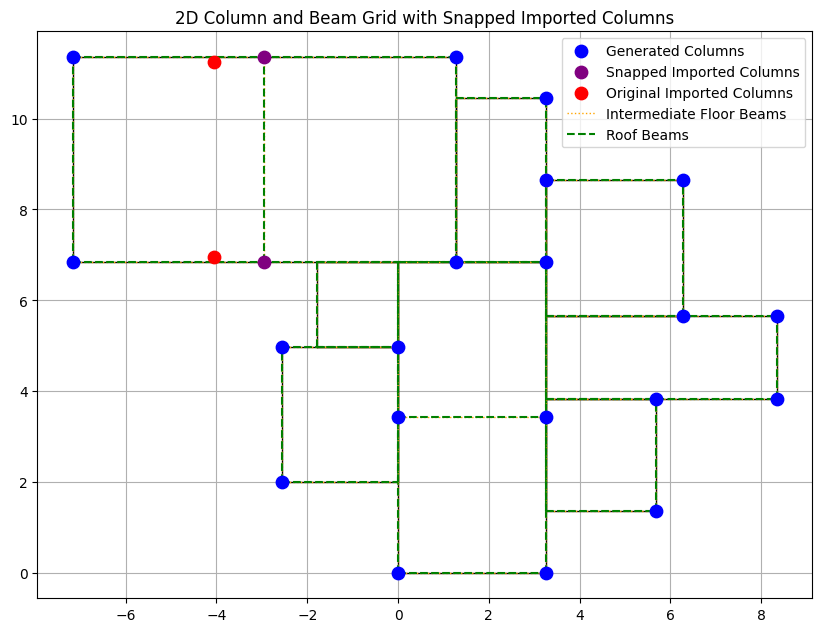

RuntimeError: No 'wall' or 'walls' layer found in the 3dm.

In [5]:
# 1. Install dependencies
!pip install -q rhino3dm shapely trimesh matplotlib pyvista

# 2. Imports
import rhino3dm
import numpy as np
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import pyvista as pv

# File path
rhino_path = r"C:\Users\papad\Documents\GitHub\Octopusie\Reference Files\rectangles3dcantilever.3dm"
if not os.path.exists(rhino_path):
    raise FileNotFoundError(f"File not found: {rhino_path}")

# Load model
model = rhino3dm.File3dm.Read(rhino_path)
layers = {layer.Name.lower(): layer.Index for layer in model.Layers}
if 'building' not in layers or ('column' not in layers and 'columns' not in layers):
    raise RuntimeError("Missing required layers: 'building' and 'column' or 'columns'.")

column_layer = 'columns' if 'columns' in layers else 'column'

# Extract building volume & height
building_volumes = []
imported_columns = []
max_z = 0.0

for obj in model.Objects:
    layer_idx = obj.Attributes.LayerIndex
    geom = obj.Geometry

    if layer_idx == layers['building'] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        base_pts = [
            [bbox.Min.X, bbox.Min.Y],
            [bbox.Max.X, bbox.Min.Y],
            [bbox.Max.X, bbox.Max.Y],
            [bbox.Min.X, bbox.Max.Y]
        ]
        building_volumes.append(Polygon(base_pts))
        max_z = max(max_z, bbox.Max.Z)

    elif layer_idx == layers[column_layer] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        center_x = (bbox.Min.X + bbox.Max.X) / 2
        center_y = (bbox.Min.Y + bbox.Max.Y) / 2
        imported_columns.append((center_x, center_y))

if not building_volumes:
    raise RuntimeError("No valid building geometry found on the 'building' layer.")

# Ask for number of floors
while True:
    try:
        num_floors = int(input("How many floors does the building have? (e.g., 2): "))
        if num_floors < 1:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive integer for the number of floors.")

# Room sorting
detected_rooms = sorted([(poly, poly.area) for poly in building_volumes], key=lambda x: -x[1])

# Structural logic
MaxS = 6.0
MinS = 3.0

columns = []
corrected_columns = []
available_imported = imported_columns.copy()
existing_columns = imported_columns.copy()
beams = []

for room_poly, _ in detected_rooms:
    minx, miny, maxx, maxy = room_poly.bounds
    width, height = maxx - minx, maxy - miny
    divisions_x = int(np.ceil(width / MaxS))
    divisions_y = int(np.ceil(height / MaxS))
    x_points = np.linspace(minx, maxx, divisions_x + 1)
    y_points = np.linspace(miny, maxy, divisions_y + 1)
    room_candidates = [(x, y) for x in x_points for y in y_points]

    for col in room_candidates:
        snap = False
        for imp_col in available_imported:
            if np.linalg.norm(np.array(col) - np.array(imp_col)) < MinS:
                corrected_columns.append(col)
                existing_columns.append(col)
                available_imported.remove(imp_col)
                snap = True
                break
        if not snap and all(np.linalg.norm(np.array(col) - np.array(exist_col)) >= MinS for exist_col in existing_columns):
            columns.append(col)
            existing_columns.append(col)

    for x in x_points:
        beams.append(((x, miny), (x, maxy)))
    for y in y_points:
        beams.append(((minx, y), (maxx, y)))

    for corner in list(room_poly.exterior.coords):
        if all(np.linalg.norm(np.array(corner) - np.array(exist_col)) >= MinS * 0.5 for exist_col in existing_columns):
            columns.append(corner)
            existing_columns.append(corner)

# Combine all base columns
all_base_columns = columns + corrected_columns

# 8. 2D Visualization (same as before)
fig, ax = plt.subplots(figsize=(10, 10))

# Room outlines
for poly, _ in detected_rooms:
    px, py = poly.exterior.xy
    ax.plot(px, py, 'k-', linewidth=1)

# Generated columns
if columns:
    gx, gy = zip(*columns)
    ax.scatter(gx, gy, c='blue', s=80, label='Generated Columns', zorder=5)

# Snapped imported columns
if corrected_columns:
    cx, cy = zip(*corrected_columns)
    ax.scatter(cx, cy, c='purple', s=80, label='Snapped Imported Columns', zorder=7)

# Original imported columns
if imported_columns:
    ix, iy = zip(*imported_columns)
    ax.scatter(ix, iy, c='red', s=80, label='Original Imported Columns', zorder=10)

intermediate_label_added = False
roof_label_added = False

for (x1, y1), (x2, y2) in beams:
    if num_floors > 1:
        for floor in range(1, num_floors):  # intermediate floors
            ax.plot([x1, x2], [y1, y2], color='orange', linestyle=':', linewidth=1,
                    label='Intermediate Floor Beams' if not intermediate_label_added else "")
            intermediate_label_added = True

    ax.plot([x1, x2], [y1, y2], color='green', linestyle='--', linewidth=1.5,
            label='Roof Beams' if not roof_label_added else "")
    roof_label_added = True

ax.set_aspect('equal', 'box')
ax.legend()
plt.title("2D Column and Beam Grid with Snapped Imported Columns")
ax.grid(True)
plt.show()

# ------------------------------------------------------------------
# ------------------------------------------------------------------
# 3-D VISUALISATION AND INTERACTION
# ------------------------------------------------------------------
plotter = pv.Plotter(title="3D Structural System")

actor_category   = {}          # actor  ➜  'column' | 'wall'
selected_columns = []          # currently-selected columns

# ------------------  COLUMNS  ------------------------------------
column_radius = 0.10
for i, (x, y) in enumerate(all_base_columns):
    col = pv.Cylinder(center=(x, y, max_z/2),
                      direction=(0, 0, 1),
                      radius=column_radius,
                      height=max_z)
    act = plotter.add_mesh(col,
                           color='blue',
                           pickable=True,
                           name=f'column_{i}')
    actor_category[act] = 'column'

# ------------------  WALLS  ---------------------------------------
# 1️⃣  Decide which layer holds your walls
wall_layer = None
for candidate in ('walls', 'wall'):       # add more names if needed
    if candidate in layers:
        wall_layer = layers[candidate]
        break
if wall_layer is None:
    raise RuntimeError("No 'wall' or 'walls' layer found in the 3dm.")

# 2️⃣  Utility – convert a rhino3dm.Mesh to a pyvista PolyData
def rhino_mesh_to_poly(mesh):
    v = np.array([[p.X, p.Y, p.Z] for p in mesh.Vertices], dtype=float)
    f = []
    for face in mesh.Faces:
        if face.IsQuad:
            f += [4, face.A, face.B, face.C, face.D]
        else:                             # triangle
            f += [3, face.A, face.B, face.C]
    return pv.PolyData(v, np.array(f))

# 3️⃣  Collect every Brep/Extrusion on the wall layer
for i, obj in enumerate(model.Objects):
    if obj.Attributes.LayerIndex != wall_layer:
        continue

    geom = obj.Geometry
    wall_meshes = []

    # 🟢 0.18+ 3dm files keep render-meshes if the model was saved from a
    #       Shaded / Rendered viewport – use them straight away.
    if hasattr(geom, "GetMeshes"):                         # Brep / Extrusion
        render_meshes = geom.GetMeshes(
            rhino3dm.MeshType.Render) or []                # may be empty
        wall_meshes += render_meshes

    # 🔴  If no meshes are embedded, rhino3dm can’t create them for you
    #     (meshing isn’t part of the library) 
    #     → fall back to a bounding-box so you still see *something*.
    if not wall_meshes:
        bbox = geom.GetBoundingBox()
        box = pv.Box(
            bounds=(bbox.Min.X, bbox.Max.X,
                    bbox.Min.Y, bbox.Max.Y,
                    bbox.Min.Z, bbox.Max.Z))
        wall_meshes = [box]

    # 4️⃣  Add every mesh (or fallback box) to the scene
    for m in wall_meshes:
        if isinstance(m, pv.PolyData):         # fallback Box is already a PV mesh
            poly = m
        else:                                  # rhino3dm.Mesh ➜ PolyData
            poly = rhino_mesh_to_poly(m)

        act = plotter.add_mesh(poly,
                               color='lightgray',
                               opacity=0.4,
                               pickable=True,
                               name=f'wall_{i}')
        actor_category[act] = 'wall'


# ------------------  BEAMS (not pickable) ------------------------
beam_radius = column_radius * 0.5
beam_sides  = 12
for (x1, y1), (x2, y2) in beams:
    for floor in range(1, num_floors + 1):
        z = (max_z / num_floors) * floor
        beam = pv.Line((x1, y1, z), (x2, y2, z)).tube(
                    radius=beam_radius, n_sides=beam_sides)
        plotter.add_mesh(beam,
                         color='green' if floor == num_floors else 'orange',
                         pickable=False)

# ------------------  PICK / DE-PICK CALLBACK ---------------------
def selection_callback(_mesh):
    act = plotter.picked_actor
    if act is None or actor_category.get(act) != 'column':
        return                        # ignore clicks on walls / empty space

    if act in selected_columns:       # 2nd click → deselect
        act.GetProperty().SetColor(0, 0, 1)      # blue
        selected_columns.remove(act)
    else:                             # 1st click → select
        act.GetProperty().SetColor(1, 1, 0)      # yellow
        selected_columns.append(act)

    plotter.render()

# register picking BEFORE adding any key handlers
plotter.enable_mesh_picking(
        selection_callback,
        left_clicking=True,
        through=False,
        show_message=True)

# ------------------  DELETE-SELECTED UTILITY --------------------
def delete_selected():
    for act in selected_columns:
        plotter.remove_actor(act)          # remove from scene
        actor_category.pop(act, None)      # clean lookup
    selected_columns.clear()
    plotter.render()

# ------------------  KEY-PRESS HANDLERS -------------------------
def _generic_keypress(vtk_obj, ev):
    key = vtk_obj.GetKeySym()              # 'Delete', 'BackSpace', 'd', ...
    if key in ('Delete', 'BackSpace', 'd', 'D'):
        delete_selected()

# catch absolutely every key that reaches the interactor
plotter.iren.add_observer("KeyPressEvent", _generic_keypress)

# guaranteed-to-work fallback for notebooks / back-ends that drop Delete
plotter.add_key_event('d', delete_selected)

# ------------------  SCENE DECOR --------------------------------
plotter.show_grid()

# ------------------  GO!  ---------------------------------------
plotter.show()       # exactly one .show() call, at the very end


In [ ]:
import pandas as pd
from collections import OrderedDict

# --- 1. Collect Unique Nodes ---
node_coords = []
node_dict = OrderedDict()
node_counter = 0

def add_node(pt):
    key = tuple(np.round(pt, 5))  # reduce float precision issues
    if key not in node_dict:
        node_id = f"N{len(node_dict)}"
        node_dict[key] = node_id
        node_coords.append([node_id] + list(key))
    return node_dict[key]

# --- 2. Create Column & Beam Connections ---
column_lines = []
beam_lines = []

for x, y in all_base_columns:
    btm = (x, y, 0)
    top = (x, y, max_z)
    id_btm = add_node(btm)
    id_top = add_node(top)
    column_lines.append((id_btm, id_top))

for (x1, y1), (x2, y2) in beams:
    pt1 = (x1, y1, max_z)
    pt2 = (x2, y2, max_z)
    id1 = add_node(pt1)
    id2 = add_node(pt2)
    beam_lines.append((id1, id2))

# --- 3. Export nodes.csv ---
df_nodes = pd.DataFrame(node_coords, columns=["ID", "X", "Y", "Z"])
df_nodes.to_csv("nodes4.csv", index=False)
print("✅ nodes.csv written.")

# --- 4. Export columns.csv ---
col_data = []
for i, (i_node, j_node) in enumerate(column_lines):
    p1 = df_nodes[df_nodes["ID"] == i_node][["X", "Y", "Z"]].values[0]
    p2 = df_nodes[df_nodes["ID"] == j_node][["X", "Y", "Z"]].values[0]
    length = np.linalg.norm(p2 - p1)
    col_data.append([f"C{i}", i_node, j_node, round(length, 3)])

df_cols = pd.DataFrame(col_data, columns=["ID", "i_node", "j_node", "length"])
df_cols.to_csv("columns4.csv", index=False)
print("✅ columns.csv written.")

# --- 5. Export beams.csv ---
beam_data = []
for i, (i_node, j_node) in enumerate(beam_lines):
    p1 = df_nodes[df_nodes["ID"] == i_node][["X", "Y", "Z"]].values[0]
    p2 = df_nodes[df_nodes["ID"] == j_node][["X", "Y", "Z"]].values[0]
    length = np.linalg.norm(p2 - p1)
    beam_data.append([f"B{i}", i_node, j_node, round(length, 3)])

df_beams = pd.DataFrame(beam_data, columns=["ID", "i_node", "j_node", "length"])
df_beams.to_csv("beams4.csv", index=False)
print("✅ beams.csv written.")


✅ nodes.csv written.
✅ columns.csv written.
✅ beams.csv written.
